In [1]:
from xgboost import XGBClassifier

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rc("font", size=14)
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split
#from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)


In [3]:
import shap
shap.initjs()

In [4]:
from azureml.core import Workspace, Dataset

subscription_id = '6ed9d167-b2e6-41b8-9500-35e6df64d9dc'
resource_group = 'MLRG'
workspace_name = 'erbbimlws'

workspace = Workspace(subscription_id, resource_group, workspace_name)

dataset = Dataset.get_by_name(workspace, name='Primary_Bank')
df = dataset.to_pandas_dataframe()

In [5]:
pd.set_option('max_columns', None) #display all columns
#pd.reset_option(“max_columns”) #to return to default

In [6]:
#df.head()

<AxesSubplot:title={'center':'New_Primary_Bank_Flag'}, ylabel='New_Primary_Bank_Flag'>

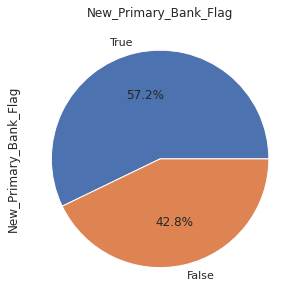

In [7]:
df['New_Primary_Bank_Flag'].value_counts().plot(kind = 'pie',y = 'New_Primary_Bank_Flag',figsize=(5, 5),title = 'New_Primary_Bank_Flag',autopct='%1.1f%%')


In [8]:
df = df.drop(columns = ['Customer_ID','Year','Month','Legal_Person', 'Active_Customer', 'Priority_Segment',	'Primary_Bank','Group_Sales_Group_Code'])

In [9]:
def binF(x):
    if x is False:
        z = 0
    elif math.isnan(x):
        z = 0
    else:
        z =1
    return z

In [10]:
df['New_Primary_Bank_Flag'] = df['New_Primary_Bank_Flag'].apply(binF)

In [11]:
#dummy variables
for col in df.columns:       
       if df[col].dtypes=='object':
            df = pd.get_dummies(df, prefix=col + '_', columns=[col])
    

In [12]:
for col in df.columns:       
       if df[col].dtypes=='datetime64[ns]':
            df = df.drop(columns = col)


In [13]:
def replace_gt(x):
    x = x.replace('<=','le ')
    x = x.replace('>=','ge')
    x = x.replace('>','gt ')
    x = x.replace('<','lt ')
    return x

In [14]:
df.columns = [replace_gt(x) for x in df.columns]

In [15]:
df.head()

,SB_Customer,Total_Funds_Balances_Avg_1M,Total_Deposits_Balances_Avg_1M,Total_Loans_Balances_OutStanding_1M,Total_Deposits_All_Beneficieries_Balances_Avg_1M,Total_Funds_All_Beneficieries_Balances_Avg_1M,Bucket_Max_1M,Bucket_Max_1Y,Bucket_Months_Count_1Y,Days_Since_Last_Transaction,Age,POS_Balance_Sum_1Y,Checks_Issued_Last_1Y_Num,Checks_Issued_Last_1Y_Amount,Checks_Issued_MaxAmount_1Y,Checks_Issued_DaysSince_1Y,Remmitances_Out_GR_Num_Sum_1Y,Remmitances_Out_GR_Amount_Sum_1Y,Remmitances_Out_GR_Amount_Max_1Y,Remmitances_Out_GR_DaysSince_1Y,Remmitances_Out_nonGR_Num_Sum_1Y,Remmitances_Out_nonGR_Amount_Sum_1Y,Remmitances_Out_nonGR_Amount_Max_1Y,Remmitances_Out_nonGR_DaysSince_1Y,Remmitances_In_GR_Num_Sum_1Y,Remmitances_In_GR_Amount_Sum_1Y,Remmitances_In_GR_1Y_Amount_Max_1Y,Remmitances_In_GR_DaysSince_1Y,Remmitances_In_nonGR_Num_Sum_1Y,Remmitances_In_nonGR_Amount_Sum_1Y,Remmitances_In_nonGR_Amount_Max_1Y,Remmitances_In_nonGR_DaysSince_1Y,Rescheduling_Flag,Epistofi_Purchases_Num_Sum_6M,Epistofi_Points_Amount_Sum_6M,Epistofi_Redeemed_Amount_Sum_6M,Epistofi_Redeemed_Amount_Max_6M,Epistofi_Redemptions_Num_Sum_6M,SafeBox_active,CC_BasicNeeds_Purchases_Num_Sum_6M,CC_BasicNeeds_Purchases_Amount_Sum_6M,CC_BasicNeeds_Purchases_Amount_Max_6M,CC_HouseNeeds_Purchases_Num_Sum_6M,CC_HouseNeeds_Purchases_Amount_Sum_6M,CC_HouseNeeds_Purchases_Amount_Max_6M,CC_PersonalNeeds_Purchases_Num_Sum_6M,CC_PersonalNeeds_Purchases_Amount_Sum_6M,CC_PersonalNeeds_Purchases_Amount_Max_6M,DC_BasicNeeds_Purchases_Num_Sum_6M,DC_BasicNeeds_Purchases_Amount_Sum_6M,DC_BasicNeeds_Purchases_Amount_Max_6M,DC_HouseNeeds_Purchases_Num_Sum_6M,DC_HouseNeeds_Purchases_Amount_Sum_6M,DC_HouseNeeds_Purchases_Amount_Max_6M,DC_PersonalNeeds_Purchases_Num_Sum_6m,DC_PersonalNeeds_Purchases_Amount_Sum_6M,DC_PersonalNeeds_Purchases_Amount_Max_6M,Total_Funds_Balance_Min_Ever,Total_Funds_Balance_Max_Ever,Total_Trans_Num_Sum_6M,Total_Trans_Amount_Sum_6M,Total_Trans_Days_Count_6M,Credit_Trans_Num_Sum_6M,Credit_Trans_Amount_Sum_6M,Credit_Trans_Days_Count_6M,Debit_Trans_Num_Sum_6M,Debit_Trans_Amount_Sum_6M,Debit_Trans_Days_Count_6M,Branch_Trans_Num_Sum_6M,Branch_Trans_Amount_Sum_6M,Branch_Trans_Days_Count_6M,ATM_Trans_Num_Sum_6M,ATM_Trans_Amount_Sum_6M,ATM_Trans_Days_Count_6M,Phone_Trans_Num_Sum_6M,Phone_Trans_Amount_Sum_6M,Phone_Trans_Days_Count_6M,EB_Trans_Num_Sum_6M,EB_Trans_Amount_Sum_6M,EB_Trans_Days_Count_6M,APS_Trans_Num_Sum_6M,APS_Trans_Amount_Sum_6M,APS_Trans_Days_Count_6M,LivePay_Trans_Num_Sum_6M,LivePay_Trans_Amount_Sum_6M,LivePay_Trans_Days_Count_6M,Payments_Trans_Num_Sum_6M,Payments_Trans_Amount_Sum_6M,Payments_Trans_Days_Count_6M,Remittance_Trans_Num_Sum_6M,Remittance_Trans_Amount_Sum_6M,Remittance_Trans_Days_Count_6M,CC_Total_Purchases_Num_Sum_6M,CC_Total_Purchases_Amount_Sum_6M,CC_Total_Purchases_Amount_Max_6M,DC_Total_Purchases_Num_Sum_6M,DC_Total_Purchases_Amount_Sum_6M,DC_Total_Purchases_Amount_Max_6M,Group_Sales_Payments_Num_Sum_6M,Group_Sales_Payment_Months_Distinct_6M,Group_Sales_Salary_Avg_6M,Group_Sales_Active_Flag,Trn_Deposit_Num_Sum_6M,Trn_Deposit_Amount_Sum_6M,Trn_Deposit_Days_Count_6M,Trn_Withdrawal_Num_Sum_6M,Trn_Withdrawal_Amount_Sum_6M,Trn_Withdrawal_Days_Count_6M,Trn_InternalTransfer_Num_Sum_6M,Trn_InternalTransfer_Amount_Sum_6M,Trn_InternalTransfer_Days_Count_6M,Trn_EurobankCheckDeposit_Num_Sum_6M,Trn_EurobankCheckDeposit_Amount_Sum_6M,Trn_EurobankCheckDeposit_Days_Count_6M,Trn_Checkpayment_Num_Sum_6M,Trn_Checkpayment_Amount_Sum_6M,Trn_Checkpayment_Days_Count_6M,Trn_OtherbankCheckDeposit_Num_Sum_6M,Trn_OtherbankCheckDeposit_Amount_Sum_6M,Trn_OtherbankCheckDeposit_Days_Count_6M,Trn_ChecksOther_Num_Sum_6M,Trn_ChecksOther_Amount_Sum_6M,Trn_ChecksOther_Days_Count_6M,Trn_EurobankCheckIssue_Num_Sum_6M,Trn_EurobankCheckIssue_Amount_Sum_6M,Trn_EurobankCheckIssue_Days_Count_6M,Trn_TimeDeposit_Num_Sum_6M,Trn_TimeDeposit_Amount_Sum_6M,Trn_TimeDeposit_Days_Count_6M,Trn_CashAdvance_Num_Sum_6M,Trn_CashAdvance_Amount_Sum_6M,Trn_CashAdvance_Days_Count_6M,Trn_LoanCardPayment_

In [179]:
x_train, x_test, y_train, y_test = train_test_split(df.loc[:,df.columns !='New_Primary_Bank_Flag'].fillna(0), df['New_Primary_Bank_Flag'].fillna(0), test_size=0.25, random_state=0)
#x_train, x_test, y_train, y_test = train_test_split(df.loc[:,important_features].fillna(0), df['New_Primary_Bank_Flag'].fillna(0), test_size=0.25, random_state=0)


In [190]:
xgb = XGBClassifier(label_encoder = False,max_depth = 5,colsample_bytree=0.5,reg_alpha =500)

In [191]:
xgb.fit(x_train,y_train,early_stopping_rounds =10, eval_metric = 'aucpr', eval_set = [(x_test,y_test)],verbose = False)

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[10:36:50] WARNING: /tmp/build/80754af9/xgboost-split_1619724447847/work/src/learner.cc:541: 
Parameters: { label_encoder } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              label_encoder=False, learning_rate=0.300000012, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=2,
              num_parallel_tree=1, random_state=0, reg_alpha=500, reg_lambda=1,
              scale_pos_weight=1, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [192]:
print(classification_report(y_train,  xgb.predict(x_train)))

              precision    recall  f1-score   support

           0       0.77      0.68      0.72      7453
           1       0.78      0.84      0.81      9796

    accuracy                           0.77     17249
   macro avg       0.77      0.76      0.77     17249
weighted avg       0.77      0.77      0.77     17249



In [193]:
print('Accuracy of XGBoost classifier on train set: {:.4f}'.format(xgb.score(x_train, y_train)))

Accuracy of XGBoost classifier on train set: 0.7731


In [194]:
print(classification_report(y_test,  xgb.predict(x_test)))

              precision    recall  f1-score   support

           0       0.76      0.66      0.71      2399
           1       0.78      0.85      0.81      3351

    accuracy                           0.77      5750
   macro avg       0.77      0.76      0.76      5750
weighted avg       0.77      0.77      0.77      5750



In [195]:
print('Accuracy of XGBoost classifier on test set: {:.4f}'.format(xgb.score(x_test, y_test)))

Accuracy of XGBoost classifier on test set: 0.7706


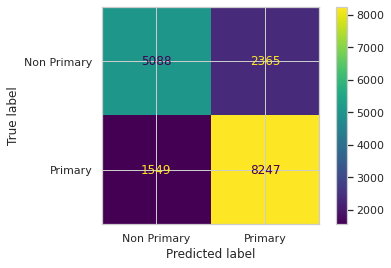

In [196]:
plot_confusion_matrix(xgb,x_train,y_train,display_labels = ['Non Primary', 'Primary'])

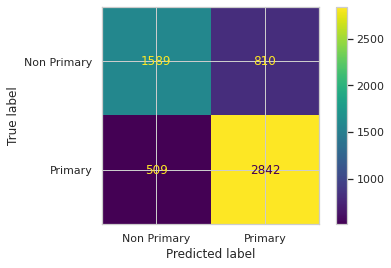

In [197]:
plot_confusion_matrix(xgb,x_test,y_test,display_labels = ['Non Primary', 'Primary'])

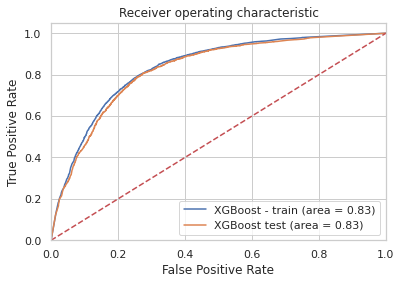

In [198]:
logit_roc_auc = roc_auc_score(y_train.to_numpy(), xgb.predict(x_train))
fpr, tpr, thresholds = roc_curve(y_train.to_numpy(), xgb.predict_proba(x_train)[:,1])
auc_train = roc_auc = auc(fpr, tpr)

logit_roc_auc = roc_auc_score(y_test, xgb.predict(x_test))
fpr_t, tpr_t, thresholds_t = roc_curve(y_test, xgb.predict_proba(x_test)[:,1])
auc_test = roc_auc = auc(fpr_t, tpr_t)

plt.plot(fpr, tpr, label='XGBoost - train (area = %0.2f)' % auc_train)
plt.plot(fpr_t, tpr_t, label='XGBoost test (area = %0.2f)' % auc_test)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")

In [199]:
explainer = shap.TreeExplainer(xgb, x_train)
shap_values = explainer.shap_values(x_test)
x_test_array = x_test.to_numpy() # we need to pass a dense version for the plotting functions

In [200]:
#shap.summary_plot(shap_values, x_test_array,x_test.columns)


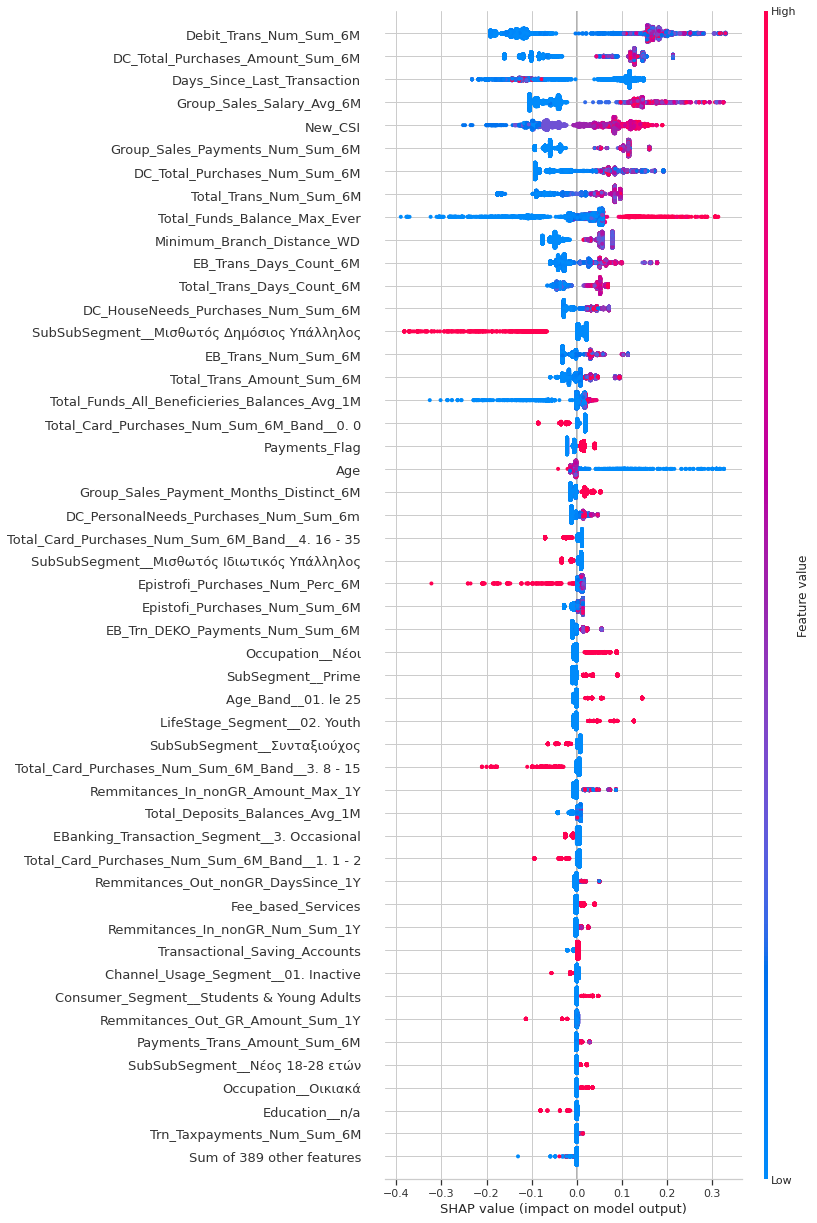

In [201]:
shap.plots.beeswarm(explainer(x_test),max_display = 50)

In [202]:
pd.set_option('display.max_rows', None)

In [203]:
important_features = pd.DataFrame(xgb.feature_importances_,x_train.columns,columns =['Importance'])\
    .sort_values(by='Importance', ascending = False).head(10).index.tolist()


In [204]:
important_features

['DC_Total_Purchases_Amount_Sum_6M',
 'Group_Sales_Payments_Num_Sum_6M',
 'Debit_Trans_Num_Sum_6M',
 'Minimum_Branch_Distance_WD',
 'Age_Band__01. le 25',
 'DC_Total_Purchases_Num_Sum_6M',
 'EB_Trans_Days_Count_6M',
 'Days_Since_Last_Transaction',
 'Total_Trans_Amount_Sum_6M',
 'Group_Sales_Salary_Avg_6M']